### Artistic Style Transfer 
(using Alex Net model)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from alexnet import alexNet
from IPython.display import display, clear_output
import numpy
import numpy as np
import scipy
import theano
import theano.tensor as T


### Functions for preprocessing and dreprocessing image, 
Preprocessing: Adding a mean value to the channels
- Run as it is:

In [5]:
%matplotlib inline

import numpy as np
from os import listdir
from os.path import isfile, join

from scipy import misc
import matplotlib.pyplot as plt
theano.config.floatX='float32'


MEAN_VALUES = np.array([109, 117, 117]).reshape((3,1,1)) # set mean image values here
#help sought from :https://github.com/Lasagne/Recipes/blob/master/examples/styletransfer/Art%20Style%20Transfer.ipynb
def preprocess_image(path):
   
    
    f = misc.imread(path) 
    min_dim, max_dim = np.argmin(f.shape[:2]), np.argmax(f.shape[:2])

    resize_scale = 227.0/f.shape[min_dim]

    f = misc.imresize(f,[int(f.shape[0]*resize_scale),int(f.shape[1]*resize_scale)]) #taking the central cropped part 
    f = f[int((f.shape[0]-227.0)/2):int((f.shape[0]-227.0)/2)+227, int((f.shape[1]-227.0)/2):int((f.shape[1]-227.0)/2)+227, :]

    
    print 'image shape(before) : ',f.shape
    f = np.transpose(f,(2,0,1))  #converting RGB to BGR 
    print 'image shape(after) : ',f.shape

    print 'f.type : ', f.dtype
    preprocessed_img = f.astype(np.float32)-MEAN_VALUES    
    preprocessed_img= numpy.asarray(preprocessed_img[np.newaxis], dtype=theano.config.floatX)
    print (preprocessed_img.shape)
    return preprocessed_img, preprocessed_img.shape



def deprocess_image(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    x = np.clip(x, 0, 255).astype('uint8')
    return x


### Provide content_image here as argument to content_image_path and run the cell


image shape(before) :  (227, 227, 3)
image shape(after) :  (3, 227, 227)
f.type :  uint8
(1, 3, 227, 227)


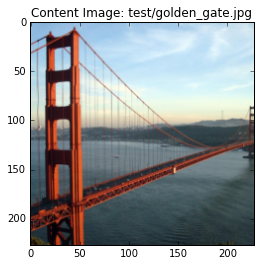

In [6]:
content_image_path='test/golden_gate.jpg'

content_image, content_shape=preprocess_image(content_image_path)
content = np.reshape(content_image,(content_shape[0], np.prod(content_shape[1:]))).astype(np.float32)
plt.imshow(deprocess_image(content_image))
plt.title("Content Image: "+content_image_path)

### Provide style_image here as argument to style_image_path and run the cell

image shape(before) :  (227, 227, 3)
image shape(after) :  (3, 227, 227)
f.type :  uint8
(1, 3, 227, 227)


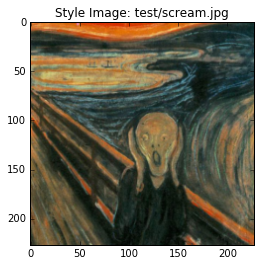

In [7]:
style_image_path = 'test/scream.jpg'

style_image, style_shape=preprocess_image(style_image_path)
style = np.reshape(style_image, (style_shape[0], np.prod(style_shape[1:]))).astype(np.float32)   
plt.imshow(deprocess_image(style_image))
plt.title("Style Image: "+style_image_path)

### Provide the layers to be considered for style loss and content_loss as the names, see the respective class to get better understanding of layers

In [8]:
style_layers = ['pool0','pool1','layer2','layer3_output','pool4']
content_layers = ['pool0']

a=preprocess_image('test_images/tubingen.jpg')
plt.imshow(deprocess_image(a))

### Loading ALEX-NET models
- alexInput = alexModel initialized with weights from .mat file
- and extracting the relevant outputs of the layer with respective inputs

In [9]:
alexInput = alexModel = alexNet("parameters_alexnet")

styleList = {
    'pool0': alexInput.pool0.eval({alexInput.x: style}),
    'pool1':alexInput.pool1.eval({alexInput.x: style}),
    'layer2':  alexInput.layer2.output.eval({alexInput.x: style}),
    'layer3_output':alexInput.layer3_output.eval({alexInput.x: style}),
    'pool4':alexInput.pool4.eval({alexInput.x: style})
}
contentList = {
    'pool0': alexInput.pool0.eval({alexInput.x : content})
}



Alexnet built


### This function defines the loss

In [10]:

def mrf_loss(art_img, gen_img, C, W, H):
    print ("MF Fields")
    print art_img.shape
    k=30
    overlap=15
    B=1
#     C, W, H= art_img.shape
    art_img=art_img
    i_start=0
    j_start=0
    i_end=29
    j_end=29
    shi=[]
    while i_end <W:
        while j_end <H:
            if(i_end >= W):
                i_end=W-1
            if(j_end >= H):
                j_end=H-1
            temp_gram_matrix_art=gram_matrix(art_img[: ,i_start:i_end, j_start:j_end])
            temp_gram_matrix_gen=gram_matrix(gen_img[: ,i_start:i_end, j_start:j_end])
            temp_x = art_img.shape[1]
            temp_y = (i_end-i_start+1)*(j_end-j_start+1)
            shi.append(1./(4 * temp_x**2 * temp_y**2) * ((temp_gram_matrix_gen - temp_gram_matrix_art)**2).sum())

            j_start=j_start+overlap
            j_end=j_end+overlap
        i_start=i_start+overlap
        i_end=i_end+overlap
        j_start=0
        j_end=29
    if(i_end >= W):
        i_end=W-1
    if(j_end >= H):
        j_end=H-1
    temp_gram_matrix_art=gram_matrix(art_img[: ,i_start:i_end, j_start:j_end])
    temp_gram_matrix_gen=gram_matrix(gen_img[: ,i_start:i_end, j_start:j_end])
    temp_x = art_img.shape[1]
    temp_y = (i_end-i_start+1)*(j_end-j_start+1)
    shi.append(1./(4 * temp_x**2 * temp_y**2) * ((temp_gram_matrix_gen - temp_gram_matrix_art)**2).sum())
    i_start=i_start+overlap
    i_end=i_end+overlap
    j_start=j_start+overlap
    j_end=j_end+overlap
    #gram_matrix_art = gram_matrix(art_img,art_img)
    #gram_matrix_gen = gram_matrix(gen_img,art_img)
    
    #x = art_img.shape[1]
    #y = art_img.shape[2] * art_img.shape[3]
    shi=np.array(shi)
    loss = shi.sum()
    return loss

def content_loss(gen_img, orig_img):
    return T.sum(T.sum(T.sum(T.sqr(gen_img-orig_img))))/2.0

def gram_matrix(X):
    X_flat = T.reshape(X,(X.shape[0],X.shape[1]*X.shape[2]))
    return T.dot(X_flat, X_flat.T)

def style_loss(gen_img,style_img,d):
    gen = gram_matrix(gen_img)
    style = gram_matrix(style_img)
    return ((1/(2.*d))**2)*(T.sum(T.pow(gen-style,2)))

def variational_loss(x,content_shape=(1,3,224,224)):
    x = x.reshape(content_shape)
    return  (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

def compute_loss (alpha, beta, style_layers, content_layers, MRF=False, content_shape=(1,3,227,227)):
# alpha, beta,style_layers, content_layers, MRF=False,
    loss = 0
    # add content loss
    loss += alpha * content_loss(alexInput.pool0,contentList['pool0'])  

    for layer in style_layers:
        if(layer=='layer2'):
            gen_img = getattr(alexInput, layer, None).output[0]
        else:
            gen_img = getattr(alexInput, layer, None)[0]
        style_img = styleList[layer][0]
        c =style_img.shape[-3]
        h = style_img.shape[-1]
        w = style_img.shape[-2]
    
        if(MRF):
            loss += beta*mrf_loss(gen_img,style_img,c,w,h)
        else:
            loss+=beta*style_loss(gen_img,style_img, c*w*h)
        
    loss+=0.1e-7*variational_loss(alexInput.x, content_shape)
    
    return loss

### This function defines th loss function for traiing the cDNN
-algorithm adopted from A Neural Algorithm of Artistic Style (https://arxiv.org/pdf/1508.06576v2.pdf)

In [13]:
def train_style(alpha, beta, n_epochs=50,filestring="",MRF=False):

 
    loss = compute_loss(alpha, beta, style_layers, content_layers,MRF=False, content_shape=content_shape)

    grad = T.grad(loss, alexInput.x)

    input_img = np.reshape(np.random.normal(0,1,size=content_shape),(content_shape[0], np.prod(content_shape[1:]))).astype(np.float32)
    inputImg = theano.shared(input_img)

    input_img=np.reshape(input_img,(content_shape)).astype(np.float32)
    inputImg = theano.shared(input_img)

    x0 = inputImg.get_value().astype(np.float32)
    
    loss_grad_fct = theano.function([],[loss,grad],givens={alexInput.x: inputImg.flatten(2)})

    # Code adapted from : https://github.com/fchollet/keras/blob/master/examples/neural_style_transfer.py
    
    def eval_loss_and_grad(x1):
        x1 = np.asarray((x1.reshape(content_shape)),dtype=theano.config.floatX)
        inputImg.set_value(x1)
        out = loss_grad_fct()
        loss_val = out[0]
        
        grad_val = np.ones(np.prod(content_shape[1:]))-1+(np.array(out[1:]).flatten())
        return loss_val,grad_val


    class loss_grad_eval():
        def __init__(self):
            self.loss_value = None
            self.grad_values = None
        def loss(self,x1):
            loss_value,grad_values =  eval_loss_and_grad(x1)
            self.loss_value = loss_value
            self.grad_values = grad_values
            return self.loss_value
        def grads(self,x1):
            assert self.loss_value is not None
            grad_values = np.copy(self.grad_values)
            self.loss_value = None
            self.grad_values = None
            return grad_values

    print('Start Training')
    
    fig=plt.figure()
    outImg = inputImg.get_value()
    plotImg=deprocess_image(outImg.reshape(content_shape))
    fig_handle = plt.imshow(plotImg.astype(np.uint8))
    display(fig)
    evaluator = loss_grad_eval()
    
    for i in range(n_epochs):        
      
        new_im, min_val, info = scipy.optimize.fmin_l_bfgs_b(evaluator.loss, x0.flatten(), fprime=evaluator.grads, maxfun=20)
        new_im = np.reshape(new_im, content_shape)
        inputImg.set_value(new_im.astype(np.float32))
        x0 = inputImg.get_value().astype(np.float32)

        outImg = inputImg.get_value()
        plotImg=deprocess_image(outImg.reshape(content_shape))
        fig_handle.set_data(plotImg.astype(np.uint8))
        clear_output(wait=True)
        display(fig)
        
        if(1):
            print ('data/results/'+filestring+str(i)+'.jpg')
            plt.imsave('data/results/'+filestring+str(i)+'.jpg',plotImg.astype(np.uint8))

### Run the code for ALEX-net 
-alpha is the weight of content image and beta is the weight of style image. 

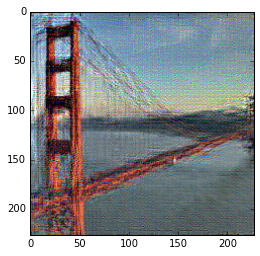

data/results/alex_19.jpg


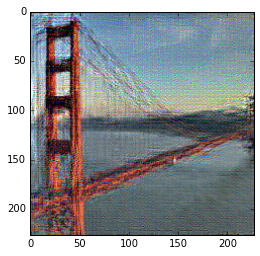

In [15]:
train_style(alpha=1, beta=0.2e-2, n_epochs=20,filestring="alex_", MRF=False)
